# Online Convex Opitmization: Project

**M2A**
* BIZON MONROC Claire
* BASILE Etienne
* ROUGE Jacques

In [1]:
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
sns.set_style("darkgrid")
sns.set_palette("gist_rainbow_r")

## Preliminary

We start by loading and preparing the MNIST data.

In [3]:
train = pd.read_csv("data/mnist_train.csv", header=None).values
test = pd.read_csv("data/mnist_test.csv", header=None).values

In [4]:
train.shape, test.shape

((60000, 785), (10000, 785))

The **task** is the binary classification of 0 vs other digits.

We therefore create the labels:
* 1 for a  0 
* -1 for any other digit.

We normalize the pixel vectors into a [0;1] interval by dividing by their maximum and add an intercept !

In [5]:
#Separate samples from labels and create Labels
traina, trainb = train[:, 1:], (train[:, 0] == 0).astype(int) * 2 - 1
testa, testb = test[:, 1:] , (test[:, 0] == 0).astype(int) * 2 - 1

#Normalize
max_pixel = traina.max()
traina = traina / max_pixel
testa = testa / max_pixel

#Add intercepts
intercept = np.ones(traina.shape[0])
traina = np.c_[traina, intercept]
intercept = np.ones(testa.shape[0])
testa = np.c_[testa, intercept]

In [10]:
traina.shape, testa.shape

((60000, 785), (10000, 785))

Let's look at one training sample !

-1


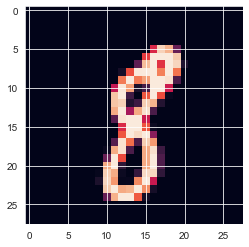

In [11]:
print(trainb[300])
plt.imshow(traina[300, :-1].reshape((28,28)))
plt.show()

We define an *Optimizer* class that will serve as a basis for the rest of the algorithms, with a function to compute the mean accuracy !

In [334]:
class Optimizer():
    def __init__(self, cost, grad):
        self.cost = cost
        self.grad = grad
        
    def _log(self, array, x, a, b):
        err = (np.sign(a@x) != b).astype(int).mean()
        array.append(err)
        return array

The binary classification task will be carried out with a *linear SVM*: the optimization problem is that of the minimization of the hinge loss over our samples.

We remind the definition of the linear SVM hinge loss:

$$\ell_{a,b}(x) = hinge(bx^Ta) = max(0, 1 - bx^Ta)$$

Applied to any $n$ samples, the optimization problem is that of the minimization of the loss function $f(x)$:

$$f(x) = \frac{1}{n} \sum_{i=1}^{n} hinge(bx^Ta_i)$$

With its $\ell2$ regularized counterpart:

$$f(x) = \frac{1}{n} \sum_{i=1}^{n} hinge(bx^Ta_i) + \frac{\lambda}{2}\Vert x \Vert^2$$

We define our raw and l2-regularized hinge loss functions, as well as their gradients.

In [43]:
def hinge(x, a, b):
    hinge = 1 - a@x * b
    hinge[hinge < 0] = 0
    return  hinge.mean()

def l2_hinge(x, a, b, lamb=1/3):
    hinge = 1 - a@x * b
    hinge[hinge < 0] = 0
    return  hinge.mean() + lamb * 0.5 * x@x

def grad_hinge(x, a, b, regularize=True):
    grad = - a * np.expand_dims(b, 1) 
    zero_values = (a@x * b) > 1
    grad[zero_values] = 0
    return grad.mean(0)
    
def l2_grad_hinge(x, a, b, lamb=1/3, regularize=True):
    grad = - a * np.expand_dims(b, 1) 
    zero_values = (a@x * b) > 1
    grad[zero_values] = 0
    return grad.mean(0) + lamb * x

Let's test our functions !

In [268]:
x = np.zeros(785)
print(hinge(x, traina, trainb))
print(grad_hinge(x, traina, trainb).shape)
print(l2_hinge(x, traina, trainb, 1/3))
print(l2_grad_hinge(x, traina, trainb, 1/3).shape)

1.0
(785,)
1.0
(785,)


## 1. Gradient Descent

We start by implementing the uncosntrained GD.

### 1.1 Unconstrained GD

In [335]:
class GradientDescent(Optimizer):
    def __init__(self, cost, grad, proj=None):
        super().__init__(cost, grad)
        self.proj = proj if proj else lambda x : x
        
    def run(self, T, a, b, test, lamb, seed=0):
        np.random.seed(seed)
        testa, testb = test
        x = np.zeros(a.shape[1])
        cost = self.cost(x, a, b, lamb)
        costs = [cost]
        errors = self._log([], x, testa, testb)
        times = [0]
        for t in range(T):
            eta = 1 / (lamb * (t+1))
            grad = self.grad(x, a, b, lamb)
            y = x - eta * grad
            x = self.proj(y)
            
            errors = self._log(errors, x, testa, testb)
            costs.append(self.cost(x, testa, testb, lamb))
            times.append(time.time())
            
        return x, np.array(costs), np.array(errors), np.array(times)

In [336]:
gd = GradientDescent(cost=l2_hinge, grad=l2_grad_hinge)

In [337]:
T = 100
start = time.time()
x, costs_ugd, errors_ugd, times_ugd = gd.run(T, traina, trainb, lamb=1/3, test=(testa, testb))
stop = time.time()
print(f"Done on {traina.shape[0]} samples in {(stop-start)/60 :.2} minutes.")

Done on 60000 samples in 0.99 minutes.


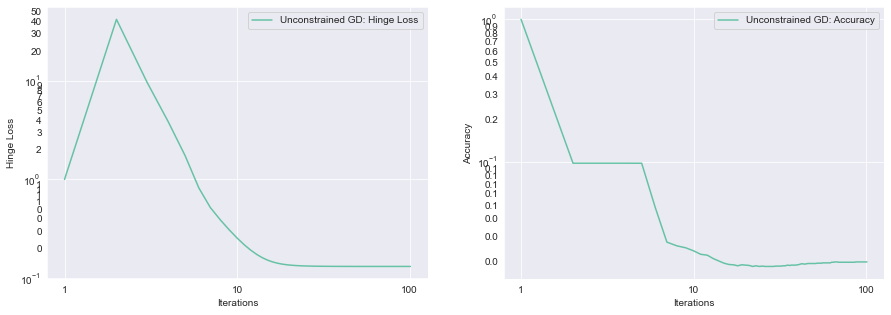

In [350]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
axes = axes.flatten()
axes[0].plot(range(1,T+2), costs_ugd, label="Unconstrained GD: Hinge Loss")
axes[0].set(xlabel="Iterations", ylabel="Hinge Loss")
axes[1].plot(range(1,T+2), errors_ugd, label="Unconstrained GD: Accuracy")
axes[1].set(xlabel="Iterations", ylabel="Accuracy")
for ax in axes:
    ax.legend()
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())

plt.show()

In [351]:
costs_ugd[-1], errors_ugd[-1]

(0.1316405034197809, 0.0199)

### 1.2 Projected GD

We define the functions for the projection on the *simplex*, and then on the $\ell1$ ball:

In [517]:
x_sorted = np.flip(np.sort(x))
cum_x_sorted = np.cumsum(x_sorted)
values = x_sorted - (cum_x_sorted - 1) / np.arange(1, x.shape[0]+1)
d = np.min(np.where(values<0)[0]) - 1
theta = (cum_x_sorted[d] - 1) / (d+1)
proj = x-theta
proj[proj<0] =0

In [523]:
def simplex_proj(x):
    x_sorted = np.flip(np.sort(x))
    cum_x_sorted = np.cumsum(x_sorted)
    values = x_sorted - (cum_x_sorted - 1) / np.arange(1, x.shape[0]+1)
    d = np.max(np.where(values>0)[0]) + 1
    theta = (cum_x_sorted[d-1] - 1) / (d)
    proj = x-theta
    proj[proj<0] = 0
    return proj

def l1_ball_proj(x, z=1):
    if np.linalg.norm(x, ord=1) <= z:
        return x
    sign_x = (x >= 0).astype(int) * 2 - 1
    w = np.abs(x) / z
    w_proj = simplex_proj(w)
    proj = sign_x * z * w_proj
    return proj

Let's test our projection:

In [528]:
for i in range(5):
    a = np.random.random(100) * 200 - 100
    proj_a = l1_ball_proj(a, 100)
    print(np.linalg.norm(a, ord=1), np.linalg.norm(proj_a, ord=1))
print(np.linalg.norm(np.ones(5),ord=1), np.linalg.norm(l1_ball_proj(np.ones(5)),ord=1))

5171.551427834223 100.00000000000006
5026.133968999622 100.00000000000001
5206.013596812681 99.99999999999997
5057.620219993589 100.00000000000038
5193.764515641952 100.00000000000001
5.0 0.9999999999999998


In [352]:
gdproj = GradientDescent(cost=l2_hinge, grad=l2_grad_hinge, proj=lambda x:l1_ball_proj(x, 100))
start = time.time()
x, costs_gdproj, errors_gdproj, times_gdproj = gdproj.run(T, traina, trainb, lamb=1/3, test=(testa, testb))
stop = time.time()
print(f"Done on {traina.shape[0]} samples in {(stop-start)/60 :.2} minutes.")

Done on 60000 samples in 0.99 minutes.


Let's check that the returned $x$ is inside the ball:

In [281]:
np.linalg.norm(x,ord=1)

8.56996296870953

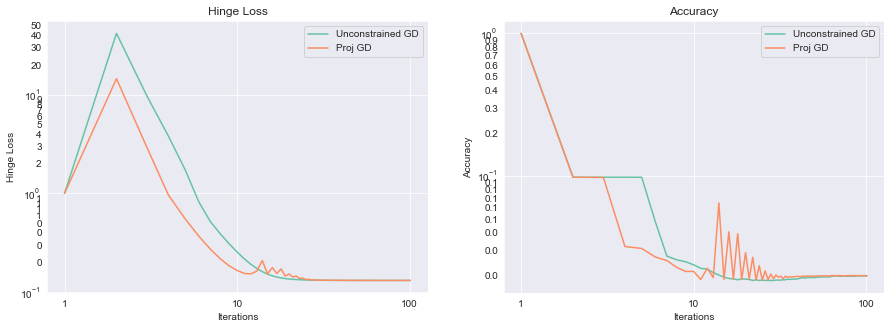

In [353]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
axes = axes.flatten()
axes[0].plot(range(1,T+2), costs_ugd, label="Unconstrained GD")
axes[0].plot(range(1,T+2), costs_gdproj, label="Proj GD")
axes[0].set(xlabel="Iterations", ylabel="Hinge Loss")
axes[0].set_title("Hinge Loss")
axes[1].plot(range(1,T+2), errors_ugd, label="Unconstrained GD")
axes[1].plot(range(1,T+2), errors_gdproj, label="Proj GD")
axes[1].set(xlabel="Iterations", ylabel="Accuracy")
axes[1].set_title("Accuracy")

for ax in axes:
    ax.legend()
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())

plt.show()

**Parameter Tuning**

Let's tune our parameters: can we improve our results by tuning the $\lambda$ and $z$ parameters ? 

Our linear SVM problem is that of the minimizing of the regularized hinge function:

$$f(x) = \frac{1}{n} \sum_{i=1}^{n} hinge(bx^Ta_i) + \frac{\lambda}{2}\Vert x \Vert^2$$.

$f(x)$ is a $\lambda$-strongly convex function. We know therefore know that it only has one solution. Moreover, we have optimal convergence guarantees on the Gradient Descent Algorithm: let $h_t = f(x_t) - f(x^*)$, with $x^*$ the minimum of $f$ and we set the learning rate for each step $t$, $\eta_t = \left(\frac{1}{\lambda t}\right)$. We have 

$$h_T = \mathcal{O}\left(\frac{1}{\lambda T}\right)$$

The smaller the radius of the $\ell$1-ball, the more sparce our vector will be. That is, we require the linear SVM to focus on a smaller subsets of the images to predict a label.

We try to tune the $z$ and $\lambda$ parameter on the Projected Gradient Descent by looking at the performance of their different combinations on the test set.

In [234]:
T = 100
lambda_range = 1 / np.arange(1,10)
z_range = [10, 50, 100, 200]
index = pd.MultiIndex.from_product([lambda_range, z_range, np.arange(T+1)], names=["lambda", "z", "t"])
tuning_df = pd.DataFrame(index=index, columns=["cost", "error", "time"])
xs = []

for l in lambda_range:
    for z in z_range:
        gdproj = GradientDescent(cost=l2_hinge, grad=l2_grad_hinge, proj=lambda x:l1_ball_proj(x, z))
        x, costs , errors, times = gdproj.run(T, traina, trainb, lamb=l, test=(testa, testb))
        tuning_df.loc[(l, z), "error"] = errors
        tuning_df.loc[(l, z), "cost"] = costs
        tuning_df.loc[(l, z), "time"] = times
        xs.append(x)

We observe the sparcity injected by the projection on the $\ell1$-ball on the different outputs $x_T$.

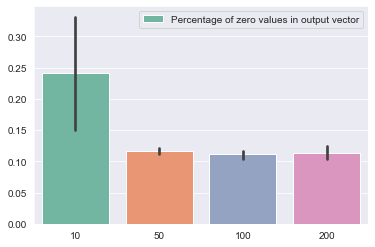

In [261]:
#Percentage of 0 values
j=0
zs = []
zeros = []
for l in lambda_range:
    for z in z_range:
        zs.append(z)
        zeros.append((xs[j]==0.0).mean())
        j+= 1
sns.barplot(zs, zeros, label="Percentage of zero values in output vector")
plt.legend()
plt.show()

Increasing the value of z above 100 does not however seem to have any further impact on scarcity.

Let's look at the effect of the tuning on the test cost:

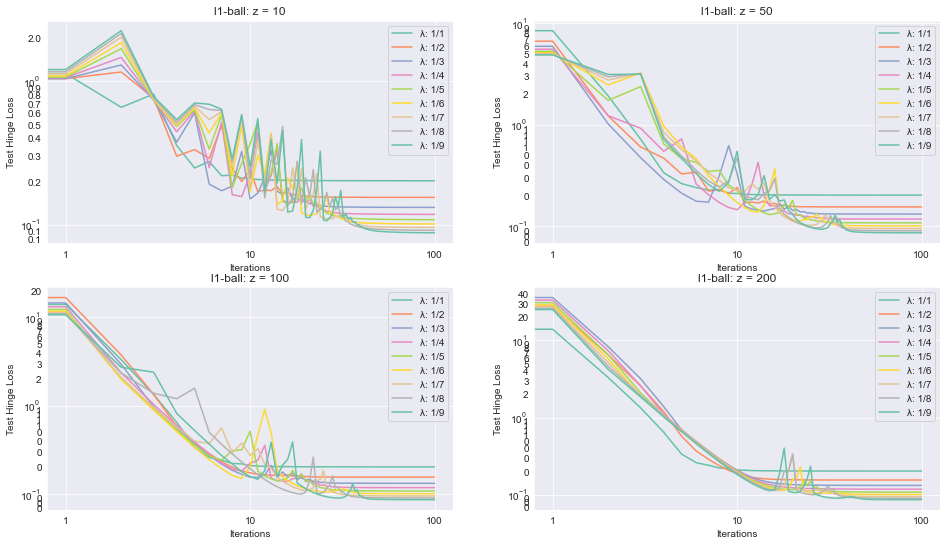

In [265]:
sns.set_palette("Set2")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,9))
axes = axes.flatten()
ls = np.arange(1,10)
for n, z in enumerate(z_range):
    ax = axes[n]
    for j, l in enumerate(lambda_range):
        errors = tuning_df.loc[(l, z, slice(None)), "cost"]
        ax.plot(range(101), errors, label=f"λ: 1/{ls[j]}")
    ax.legend()
    ax.set_title("l1-ball: z = "+str(z))
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax.set(xlabel="Iterations", ylabel="Test Hinge Loss")
plt.show()

* Optimization in smaller radius balls seem to increase instability during convergence, probability due to the stronger impact of the projection. 
* All algorithms however end up converging around the loss of 0.1. Larger step sizes tend to converge faster, but smaller step stizes tend to give better results. We get the best results with a $\lambda = \frac{1}{9}$ around and a test hinge loss of **0.085**, corresponding to an average error of **0.01** (on average, the algorithm predicts the right number 99% of the time).
* We note that although the size of the ball impacts the sparcity of the vectors, it has a very small impact on the final performance of the algorithm. This should be an argument to keep low radius balls for the sake of feature selection (better interpretability and generalization) and reduced dimensions.

## 2. Stochastic Gradient Descent

In [360]:
class StochasticGradientDescent(GradientDescent):
    def run(self, T, a, b, test, lamb, seed=0):
        np.random.seed(seed)
        testa, testb = test
        x = np.zeros(a.shape[1])
        costs = [self.cost(x, testa, testb, lamb)]
        errors = self._log([], x, testa, testb)
        times = [0]
        x_iter = []
        #Init: sample elements
        stoch_indices = np.random.randint(a.shape[0], size=T)
        stoch_a = a[stoch_indices]
        stoch_b = b[stoch_indices]
        
        for t in range(T):
            eta = 1 / (lamb * (t+1))
            grad = self.grad(x, stoch_a[None, t], stoch_b[None, t], lamb)
            y = x - eta * grad
            x = self.proj(y)
            x_iter.append(x)
            
            #Monitor error with the averaged x_t
            errors = self._log(errors, np.stack(x_iter, 0).mean(0), testa, testb)
            costs.append(self.cost(x, testa, testb, lamb))
            times.append(time.time())
            
        return np.stack(x_iter, 0).mean(0), np.array(costs), np.array(errors), np.array(times)

In [361]:
NUM_ITER = 10000

sgd = StochasticGradientDescent(cost=l2_hinge, grad=l2_grad_hinge)
start = time.time()
x, costs_usgd, errors_usgd, times_usgd= sgd.run(NUM_ITER, traina, trainb, lamb=1/3, test=(testa, testb))
stop = time.time()
print(f"Done {NUM_ITER} iterations in {(stop-start)/60 :.2} minutes.")

sgd = StochasticGradientDescent(cost=l2_hinge, grad=l2_grad_hinge, proj=lambda x: l1_ball_proj(x, 100))
start = time.time()
x, costs_sgdproj, errors_sgdproj, times_sgdproj = sgd.run(NUM_ITER, traina, trainb, lamb=1/3, test=(testa, testb))
stop = time.time()
print(f"Done {NUM_ITER} iterations in {(stop-start)/60 :.2} minutes.")

C:\Users\clair\Anaconda3\envs\papaya\lib\site-packages\ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Done 10000 iterations in 6.0 minutes.
Done 10000 iterations in 5.9 minutes.


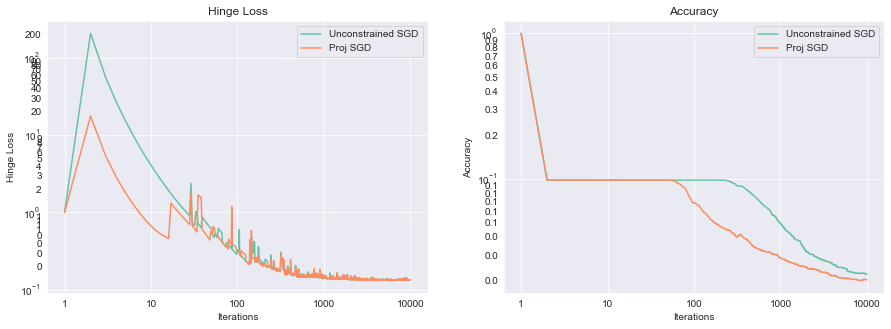

In [372]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
axes = axes.flatten()
axes[0].plot(range(1,NUM_ITER+2), costs_usgd, label="Unconstrained SGD")
axes[0].plot(range(1,NUM_ITER+2), costs_sgdproj, label="Proj SGD")
axes[0].set(xlabel="Iterations", ylabel="Hinge Loss")
axes[0].set_title("Hinge Loss")
axes[1].plot(range(1,NUM_ITER+2), errors_usgd, label="Unconstrained SGD")
axes[1].plot(range(1,NUM_ITER+2), errors_sgdproj, label="Proj SGD")
axes[1].set(xlabel="Iterations", ylabel="Accuracy")
axes[1].set_title("Accuracy")

for ax in axes:
    ax.legend()
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())

plt.show()

Let's now compare the run times between the stochastic and non stochastic gradient descent:

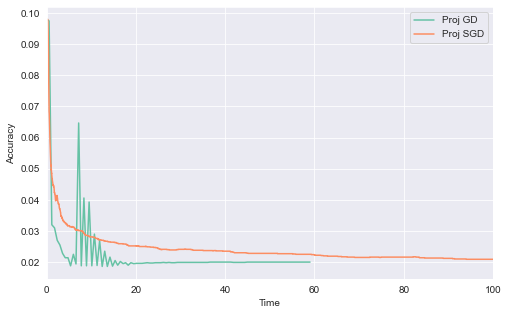

In [389]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(times_gdproj[1:]-times_gdproj[1], errors_gdproj[1:], label="Proj GD")
ax.plot(times_sgdproj[1:]-times_sgdproj[1], errors_sgdproj[1:], label="Proj SGD")
ax.legend()
ax.set(xlabel="Time", ylabel="Accuracy")
plt.xlim(0,100)
plt.show()

The Projected Gradient Descent converges faster, in approximately 20 seconds, event after oscillating. The Projected SGD takes a bit longer, apprixmately 1 minute to converge.

## 4. Regularized Follow the Leader

We implement the **Stochastic Mirror Descent**, the **Stochastic Exponentiated Gradient +/-** and the **Stochastic AdaGrad**.

### 4.1 Stochastic Mirror Descent

In [393]:
class StochasticMirrorDescent(GradientDescent):
    def run(self, T, a, b, test, seed=0):
        np.random.seed(seed)
        testa, testb = test
        x = np.zeros(a.shape[1])
        y = np.zeros(a.shape[1])
        costs = [self.cost(x, testa, testb)]
        errors = self._log([], x, testa, testb)
        x_iter = []
        times = [time.time()]
        #Init: sample elements
        stoch_indices = np.random.randint(a.shape[0], size=T)
        stoch_a = a[stoch_indices]
        stoch_b = b[stoch_indices]
        
        for t in range(T):
            eta = 1 / np.sqrt(t+1)
            cost = self.cost(x, stoch_a[None, t], stoch_b[None, t])
            grad = self.grad(x, stoch_a[None, t], stoch_b[None, t])
            y = y - eta * grad
            x = self.proj(y)
            x_iter.append(x)
            costs.append(cost)
            
            #Monitor error with the averaged x_t
            errors = self._log(errors, np.stack(x_iter, 0).mean(0), testa, testb)
            costs.append(self.cost(x, testa, testb))
            times.append(time.time())
            
        return np.stack(x_iter, 0).mean(0), np.array(costs), np.array(errors), np.array(times)

In [395]:
NUM_ITER = 10000

sgd = StochasticMirrorDescent(cost=hinge, grad=grad_hinge, proj=lambda x: l1_ball_proj(x, 100))
start = time.time()
x, costs_smdproj, errors_smdproj, times_smdproj = sgd.run(NUM_ITER, traina, trainb, test=(testa, testb))
stop = time.time()
print(f"Done {NUM_ITER} iterations in {(stop-start)/60 :.2} minutes.")

Done 10000 iterations in 5.9 minutes.


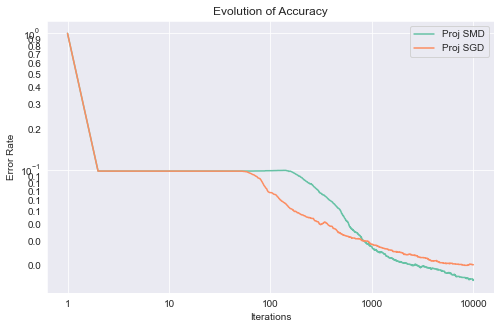

In [557]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(range(1,NUM_ITER+2), errors_smdproj, label="Proj SMD")
ax.plot(range(1,NUM_ITER+2), errors_sgdproj, label="Proj SGD")
ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.set(xlabel="Iterations", ylabel="Error Rate")
plt.title("Evolution of Accuracy")
plt.show()

The Projected **Stochastic Mirror Descent** takes more iterations to converge than the Projected SGD. It however converges towards a lower accuracy.

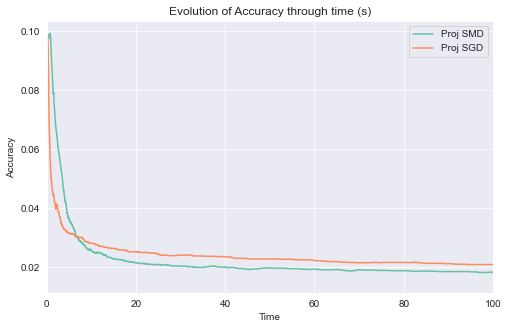

In [556]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(times_smdproj[1:]-times_smdproj[1], errors_smdproj[1:], label="Proj SMD")
ax.plot(times_sgdproj[1:]-times_sgdproj[1], errors_sgdproj[1:], label="Proj SGD")
ax.legend()
ax.set(xlabel="Time", ylabel="Accuracy")
plt.xlim(0,100)
plt.title("Evolution of Accuracy through time (s)")
plt.show()

### 4.2 Stochastic Exponentiated Gradient +/-

In [433]:
class StochasticExponentiatedGradient(GradientDescent):
    def run(self, T, a, b, test, z=100, seed=0):
        np.random.seed(seed)
        testa, testb = test
        
        d = a.shape[1]
        x = np.zeros(d)
        w = np.ones(2*d) / (2*d)
        theta = np.zeros(2*d)
        
        costs = [self.cost(x, testa, testb)]
        errors = self._log([], x, testa, testb)
        x_iter = []
        times = [time.time()]
        #Init: sample elements
        stoch_indices = np.random.randint(a.shape[0], size=T)
        stoch_a = a[stoch_indices]
        stoch_b = b[stoch_indices]
        
        for t in range(T):
            eta = 1 / np.sqrt(t+1)
            cost = self.cost(x, stoch_a[None, t], stoch_b[None, t])
            grad = self.grad(x, stoch_a[None, t], stoch_b[None, t])
            
            theta[:d] -= eta * grad
            theta[d:] += eta * grad
            w = np.exp(theta) / np.sum(np.exp(theta))
            x = z * (w[:d] - w[d:])
        
            x_iter.append(x)
            costs.append(cost)
            
            #Monitor error with the averaged x_t
            errors = self._log(errors, np.stack(x_iter, 0).mean(0), testa, testb)
            costs.append(self.cost(x, testa, testb))
            times.append(time.time())
            
        return np.stack(x_iter, 0).mean(0), np.array(costs), np.array(errors), np.array(times)

In [414]:
NUM_ITER = 10000
BALL_RADIUS = 100

sgd = StochasticExponentiatedGradient(cost=hinge, grad=grad_hinge)
start = time.time()
x, costs_segproj, errors_segproj, times_segproj = sgd.run(NUM_ITER, traina, trainb, z=BALL_RADIUS, test=(testa, testb))
stop = time.time()
print(f"Done {NUM_ITER} iterations in {(stop-start)/60 :.2} minutes.")

Done 10000 iterations in 6.0 minutes.


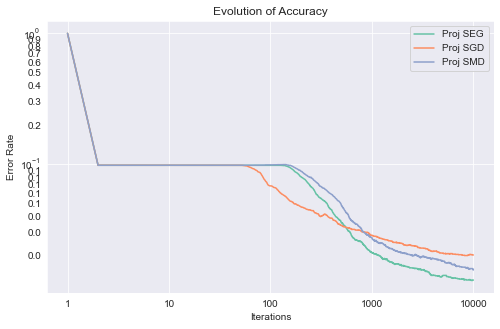

In [558]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(range(1,NUM_ITER+2), errors_segproj, label="Proj SEG")
ax.plot(range(1,NUM_ITER+2), errors_sgdproj, label="Proj SGD")
ax.plot(range(1,NUM_ITER+2), errors_smdproj, label="Proj SMD")
ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.set(xlabel="Iterations", ylabel="Error Rate")
plt.title("Evolution of Accuracy")
plt.show()

The SEG converges faster, an to a better accuracy than de SGD. The improvement over the SMD is less clear, as both algorithms could converge towards similar results with more iterations.

### 4.3 Stochastic AdaGrad

In [448]:
class StochasticAdaGrad(GradientDescent):
    def run(self, T, a, b, test, z=100, delta=1e-2, seed=0):
        np.random.seed(seed)
        testa, testb = test
        
        d = a.shape[1]
        x = np.zeros(d)
        y = np.zeros(d)
        S = np.ones(d) * delta
        
        costs = [self.cost(x, testa, testb)]
        errors = self._log([], x, testa, testb)
        x_iter = []
        times = [time.time()]
        #Init: sample elements
        stoch_indices = np.random.randint(a.shape[0], size=T)
        stoch_a = a[stoch_indices]
        stoch_b = b[stoch_indices]
        

        for t in range(T):
            grad = self.grad(x, stoch_a[None, t], stoch_b[None, t])
            S = S + grad**2
            y = x - grad / np.sqrt(S)
            x = self.proj(y, S, z)
        
            x_iter.append(x)
            
            #Monitor error with the averaged x_t
            errors = self._log(errors, np.stack(x_iter, 0).mean(0), testa, testb)
            costs.append(self.cost(x, testa, testb))
            times.append(time.time()) 
            
        return np.stack(x_iter, 0).mean(0), np.array(costs), np.array(errors), np.array(times)

In [448]:
class StochasticAdaGrad(GradientDescent):
    def run(self, T, a, b, test, z=100, delta=1e-2, seed=0):
        np.random.seed(seed)
        testa, testb = test
        
        d = a.shape[1]
        x = np.zeros(d)
        y = np.zeros(d)
        S = np.ones(d) * delta
        
        costs = [self.cost(x, testa, testb)]
        errors = self._log([], x, testa, testb)
        x_iter = []
        times = [time.time()]
        #Init: sample elements
        stoch_indices = np.random.randint(a.shape[0], size=T)
        stoch_a = a[stoch_indices]
        stoch_b = b[stoch_indices]
        

        for t in range(T):
            grad = self.grad(x, stoch_a[None, t], stoch_b[None, t])
            S = S + grad**2
            y = x - grad / np.sqrt(S)
            x = self.proj(y, S, z)
        
            x_iter.append(x)
            
            #Monitor error with the averaged x_t
            errors = self._log(errors, np.stack(x_iter, 0).mean(0), testa, testb)
            costs.append(self.cost(x, testa, testb))
            times.append(time.time()) 
            
        return np.stack(x_iter, 0).mean(0), np.array(costs), np.array(errors), np.array(times)

In [534]:
def weighted_simplex_proj(x, S):
    """
    x, S: array (d,)
    """
    weighted_x = S * x
    rank = np.flip(np.argsort(weighted_x))
    x_sorted = x[rank]
    cum_x_sorted = np.cumsum(x_sorted)
    weight_sorted = S[rank]
    weighted_x_sorted = weighted_x[rank]

    values = weighted_x_sorted - (cum_x_sorted - 1) / np.cumsum(1/weight_sorted)
    d = np.max(np.where(values>0)[0]) + 1
    theta = (cum_x_sorted[d-1] - 1) / np.sum(1/weight_sorted[:d])
    proj = weighted_x - theta
    proj[proj < 0] = 0
    proj = proj / S
    return proj

def weighted_l1_ball_proj(x, D, z=1):
    if np.linalg.norm(x, ord=1) <= z:
        return x
    #sign_x = (x >= 0).astype(int) * 2 - 1
    sign_x = np.sign(x)
    w = np.abs(x) / z
    w_proj = weighted_simplex_proj(w, D)
    proj = sign_x * z * w_proj
    return proj

In [541]:
for i in range(5):
    a = np.random.random(100) * 200 - 100
    S = np.ones(100) * 1e-2
    proj_a = weighted_l1_ball_proj(a, S, 100)
    print(np.linalg.norm(a, ord=1), np.linalg.norm(proj_a, ord=1))
print(np.linalg.norm(np.ones(100), ord=1), np.linalg.norm(weighted_l1_ball_proj(np.ones(100), S), ord=1))

4893.7245787658485 99.99999999999979
5270.27514102476 99.99999999999993
5349.06302562854 100.00000000000006
4934.423639004688 99.99999999999994
4774.351100619635 99.99999999999969
100.0 0.9999999999999938


In [542]:
NUM_ITER = 10000
BALL_RADIUS = 100

adagrad = StochasticAdaGrad(cost=hinge, grad=grad_hinge, proj=weighted_l1_ball_proj)
start = time.time()
x, costs_adagrad, errors_adagrad, times_adagrad = adagrad.run(NUM_ITER, traina, trainb, z=BALL_RADIUS, test=(testa, testb))
stop = time.time()
print(f"Done {NUM_ITER} iterations in {(stop-start)/60 :.2} minutes.")

Done 10000 iterations in 6.9 minutes.


Let's compare all the *Regularized Follow the Leader* methods:

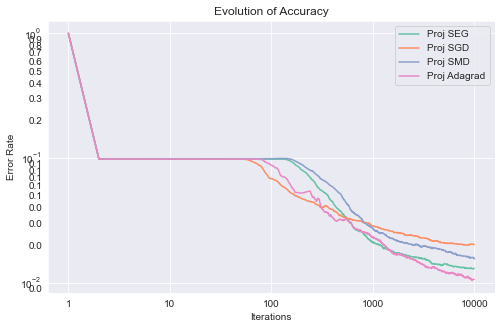

In [559]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(range(1,NUM_ITER+2), errors_segproj, label="Proj SEG")
ax.plot(range(1,NUM_ITER+2), errors_sgdproj, label="Proj SGD")
ax.plot(range(1,NUM_ITER+2), errors_smdproj, label="Proj SMD")
ax.plot(range(1,NUM_ITER+2), errors_adagrad, label="Proj Adagrad")
ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.set(xlabel="Iterations", ylabel="Error Rate")
plt.title("Evolution of Accuracy")
plt.show()

All RFLT algorithms end up **performing better than the Projected SGD**, despite converging a bit slower. Of all 3, Adagrad performs slightly better than other algorithms.

And in terms of running time ...

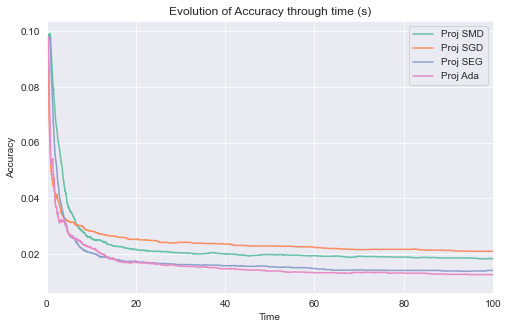

In [560]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(times_smdproj[1:]-times_smdproj[1], errors_smdproj[1:], label="Proj SMD")
ax.plot(times_sgdproj[1:]-times_sgdproj[1], errors_sgdproj[1:], label="Proj SGD")
ax.plot(times_segproj[1:]-times_segproj[1], errors_segproj[1:], label="Proj SEG")
ax.plot(times_adagrad[1:]-times_adagrad[1], errors_adagrad[1:], label="Proj Ada")
ax.legend()
ax.set(xlabel="Time", ylabel="Accuracy")
plt.xlim(0,100)
plt.title("Evolution of Accuracy through time (s)")
plt.show()

As expected, **Adagrad** and **SEG**, with their adapted learning rates, accelerate the convergence of the optimization compared to the vanilla SMD.

## 5. Incomplete Information Methods

We now implement the **Stochastic Randomized Exponentiated Gradient +/-** and discuss its convergence

We start by implementing the unregularized directionnal gradient of the hinge loss. The complexity is quite similar to the computation of the full gradient in this case.

In [417]:

def grad_hinge_dir(x, a, b,dir):
    if a.ndim == 1:
        if (a@x * b) > 1:
            return 0
        return np.mean(a[:,dir] * b )
    else:
        grad = - a[:,dir] * b
        zero_values = (a@x * b) > 1
        grad[zero_values] = 0
        return np.mean(grad)

In [418]:
d=785
import random
def SREG(T, N, z, f, grad_f, traina, trainb, lamb,testa,testb):
    x = np.zeros(d)
    I = [random.sample(list(np.arange(traina.shape[0])),N)]
    a = traina[I]
    b = trainb[I]
    sx = x
    w = np.ones(2*d)/(2*d)
    costs = [np.mean(f(x, testa, testb, lamb))]
    accuracies = []
    for t in range(1,T):
        i= np.random.choice(np.arange(0, d), p=(w[:d]+w[d:]))
        eta = np.sqrt(np.log(2*d)/(2*d*t))
        g=grad_hinge_dir(x, a, b,i)
        if g>0:
            if w[i] != 0 :
               w[i]= np.exp(-eta*g/w[i])*w[i]
        else : 
            if w[i+d]!=0:
               w[i+d] = np.exp(eta*g/w[i+d])*w[i+d]
            
        w = w/(np.sum(w))
        x=z*(w[:d]-w[d:])
        sx = sx +x
        
        if (t%10==0) :
            accuracies.append(np.sum([np.sign(testa.dot(sx/(t+1)))-testb==0])/testa.shape[0])
            costs.append(np.mean(f(sx/(t+1), testa, testb, lamb)))
            print("\r Epoch : ",t,", Mean cost = ",costs[-1], end='',flush = True)
            
    return 1/(T+1)*sx,costs,accuracies

In [ ]:
mx_2,costs_2,accuracies_2 = SREG(10000,500,1000,l2_hinge,l2_grad_hinge,traina,trainb,0, testa,testb)

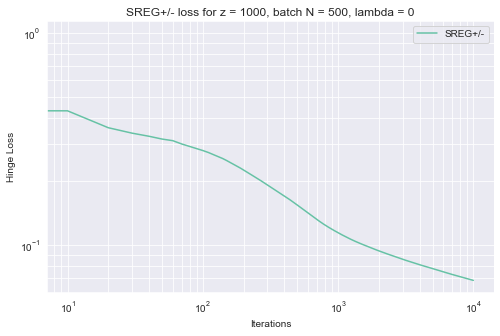

In [421]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot([10*k for k in range(1000)], costs_2, label="SREG+/-")
ax.set_title("SREG+/- loss for z = 1000, batch N = 500, lambda = 0")
ax.title
ax.legend()
ax.grid(which="minor")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set(xlabel="Iterations", ylabel="Hinge Loss")
plt.show()

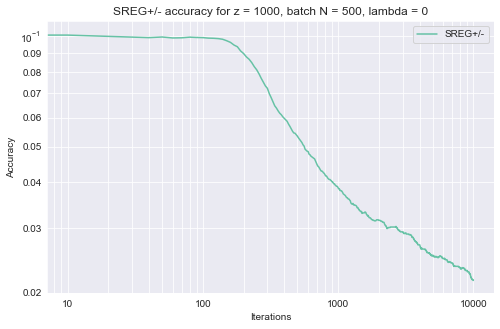

In [422]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot([10*k for k in range(999)], np.ones(999)-accuracies_2, label="SREG+/-")
ax.set_title("SREG+/- accuracy for z = 1000, batch N = 500, lambda = 0")
ax.title
ax.legend()
ax.grid(which="minor")
ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.set(xlabel="Iterations", ylabel="Accuracy")
plt.show()

We observe that with a sufficiently large z, we can pass the 0.1 barrier in a relatively small amount of steps.

In [178]:
regret = np.cumsum(costs_2)

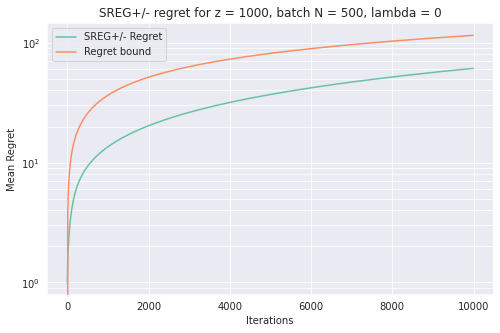

In [179]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot([10*k for k in range(1000)], regret, label="SREG+/- Regret")
ax.plot([10*k for k in range(1000)],[np.sqrt(2*np.log(d)*k) for k in range(1000)],label="Regret bound")
ax.set_title("SREG+/- regret for z = 1000, batch N = 500, lambda = 0")
ax.title
ax.legend()
ax.grid(which="minor")
ax.set_yscale("log")
ax.set(xlabel="Iterations", ylabel="Mean Regret")
plt.show()

**Conclusion**: The SREG+/- satisfies indeed the regret bound (=$\sqrt{2\log(d)*T}$)

## 6. Online Newton Step

We implement the **Stochastic Online Newton Step**.

In [454]:
class StochasticNewton(GradientDescent):
    def run(self, T, a, b, test, lamb, gamma, z=100, delta=1e-2, seed=0):
        np.random.seed(seed)
        testa, testb = test
        
        d = a.shape[1]
        x = np.zeros(d)
        y = np.zeros(d)
        S = np.ones(d) * delta
        A = np.eye(d) / (gamma**2)
        A_inv = np.eye(d) * (gamma**2)

        costs = [self.cost(x, testa, testb)]
        errors = self._log([], x, testa, testb)
        x_iter = []
        times = [time.time()]
        #Init: sample elements
        stoch_indices = np.random.randint(a.shape[0], size=T)
        stoch_a = a[stoch_indices]
        stoch_b = b[stoch_indices]

        for t in range(T):
            grad = self.grad(x, stoch_a[None, t], stoch_b[None, t])
            grad += lamb * x
            grad_moment = grad[:, None]@grad[None, :]
            
            A += grad_moment
            A_inv -= A_inv@grad_moment@A_inv / (1 + grad@A_inv@grad)
            y = x - A_inv@grad / gamma
            x = self.proj(y, np.diagonal(A), z)
        
            x_iter.append(x)

            #Monitor error with the averaged x_t
            errors = self._log(errors, np.stack(x_iter, 0).mean(0), testa, testb)
            costs.append(self.cost(x, testa, testb))
            times.append(time.time()) 
            
        return np.stack(x_iter, 0).mean(0), np.array(costs), np.array(errors), np.array(times)

In [455]:
NUM_ITER = 10000
BALL_RADIUS = 100

sgd = StochasticNewton(cost=hinge, grad=grad_hinge, proj=weighted_l1_ball_proj)
start = time.time()
x, costs_sons, errors_sons, times_sons = sgd.run(NUM_ITER, traina, trainb, lamb=1/3, gamma=1/3, z=BALL_RADIUS, test=(testa, testb))
stop = time.time()
print(f"Done {NUM_ITER} iterations in {(stop-start)/60 :.2} minutes.")

Done 10000 iterations in 1e+01 minutes.


We notice that completing the 10000 iterations took almost twice as much time for that algorithm than the others. Let's then look at the graph of convergence through time (in seconds):

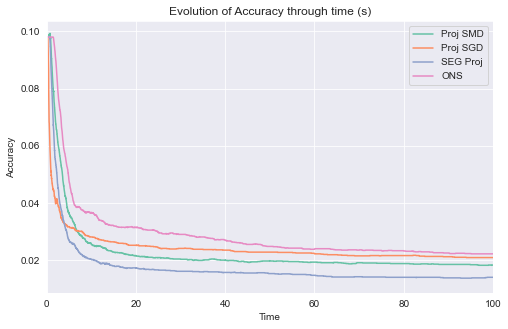

In [561]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(times_smdproj[1:]-times_smdproj[1], errors_smdproj[1:], label="Proj SMD")
ax.plot(times_sgdproj[1:]-times_sgdproj[1], errors_sgdproj[1:], label="Proj SGD")
ax.plot(times_segproj[1:]-times_segproj[1], errors_segproj[1:], label="SEG Proj")
ax.plot(times_sons[1:]-times_sons[1], errors_sons[1:], label="ONS")
ax.legend()
ax.set(xlabel="Time", ylabel="Accuracy")
plt.xlim(0,100)
plt.title("Evolution of Accuracy through time (s)")
plt.show()

As already seen, ONS **is the slowest algorithm to converge** ! It also converges to less interesting fixed point, around ~0.01 more in terms of accuracy than our RFTL algorithms.

## 7. Another algorithm: MetaGrad

We implement the **MetaGrad** algorithm from the paper:

    MetaGrad: Faster Convergence Without Curvature in Online Convex Optimization, Koolen and Erven, 2016

**2**. The objective of the MetaGrad algorithm is to optimise the learning rate, by determining at each stage the best one, and giving it a weight accordingly.

**3**. The MetaGrad algorithm worked much better than the algorithms presented in the course. Given that it combines a DMS and a weighting approach, this result could seem logical.
However, the algorithm loops twice per iteration, which makes it learn much faster.

**4**. In the article, the algorithm is much better than AdaGrad, and this is also the case in our curves. The performance is comparable to the performance described in the article.

In [415]:
def MetaSlave(eta,w,Sigma,g, gg):
      
    Sigma = Sigma - 2*eta**2 * (Sigma@gg@Sigma) / (1 + g@Sigma@g)
    y = w - (eta * Sigma@g) / (1 + 2*eta**2 * g[None, :]@Sigma@g[:,None])
    w = weighted_l1_ball_proj(y, Sigma, 100)
    return([eta,w[0],Sigma])

In [416]:
def sommepond(L,w):
    a=0
    b=0
    for k in range(len(L)):
        a = a + L[k][0] * w[k] * L[k][1]

        b = b + (L[k][0] * w[k])
    return a/b

def surrogate(u,eta,x,g,gg):
    return(-eta*(x-u)@g + eta**2 *(x-u)@gg@(x-u))

def expsurrogate(x,w,L,t,g,M,alpha =0.01):
    a = 0
    for k in range(len(L)):
        a = a + w[k] * np.exp(surrogate(L[k][1],L[k][0],x,g,M))
        
    return np.exp(surrogate(L[t][1],L[t][0],x,g,M)) / a

In [17]:
class MetaGrad(GradientDescent):
    def run(self, T, a, b, test,lamb, z=100, G = 80,seed=0):
        np.random.seed(seed)
        testa, testb = test

        d = a.shape[1]
        x = np.zeros(d)
        w = np.ones(2*d) / (2*d)
        theta = np.zeros(2*d)
        
        costs = []
        errors = []
        x_iter = []
        #Init: sample elements
        
        n_slaves = int(math.log(T,2)/2)
        print(r'number of slaves : {n_slaves}')
        l_slaves = [2**(-k) /(5*z*G) for k in range(n_slaves)]
        weights = [((1+1/float(n_slaves))/((k+1)*(k+2))) for k in range(n_slaves)]
        L_slaves = [[2**(-k) /(5*z*G),np.zeros(d),z**2 *np.eye(d)] for k in range(n_slaves)]
        print(n_slaves)
        
        # First Log
        errors = self._log(errors, x, testa, testb)
        
        
        for t in range(T):
            #predict:
            x = sommepond(L_slaves,weights)
            
            
            #observe gradient:
            cost = self.cost(x,a,b,lamb)
            grad = self.grad(x,a,b,lamb)
            
            if t%10 ==0:
                print(cost)
            gg = grad[:, None]@grad[None, :] #"Mt"
            
            #update future weights:
            L = []
            for j in range(n_slaves):
                L.append(expsurrogate(x,weights,L_slaves,j,grad,gg))
                
            weights = L
                
            #Update our metamaster:
            for k in range(n_slaves):
                L_slaves[k] = MetaSlave(L_slaves[k][0],L_slaves[k][1],L_slaves[k][2],grad,gg)           
            x_iter.append(x)
            costs.append(cost)
            
            #Monitor error with the averaged x_t
            errors = self._log(errors, np.stack(x_iter, 0).mean(0), testa, testb)      
            
        return np.stack(x_iter, 0).mean(0), np.array(costs), np.array(errors)   

In [18]:
NUM_ITER = 140
BALL_RADIUS = 100

mgd = MetaGrad(cost=l2_hinge, grad=l2_grad_hinge, proj=weighted_l1_ball_proj)
start = time.time()
x, costs_mtg, errors_mtg = mgd.run(NUM_ITER, traina, trainb, lamb=1/3, G=100, z=BALL_RADIUS, test=(testa, testb))
stop = time.time()
print(f"Done {NUM_ITER} iterations in {(stop-start)/60 :.2} minutes.")

number of slaves : {n_slaves}
3
1.0
190.9827857838405
275.44671238135254
72.14729942487823
533.1131685478297
100.44525563029002
29.834910793695865
5980.162129331011
220.67041749814956
63.681555616921486
1087.748387616638
1292.7543205789343
4987.9821625344575
85830.68993900278
Done 140 iterations in 1.2 minutes.


In [456]:
meta_results =  pd.read_csv("MetaGrad10000.csv")

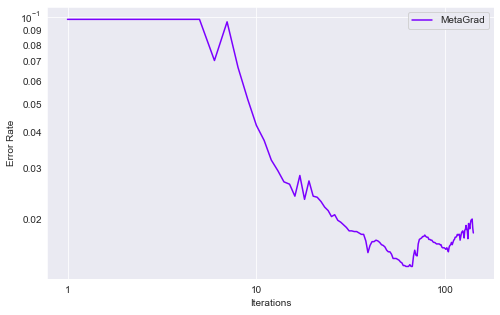

In [21]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(range(1,142), errors_mtg, label="MetaGrad")
ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.set(xlabel="Iterations", ylabel="Error Rate")
plt.show()

## Final Graph !

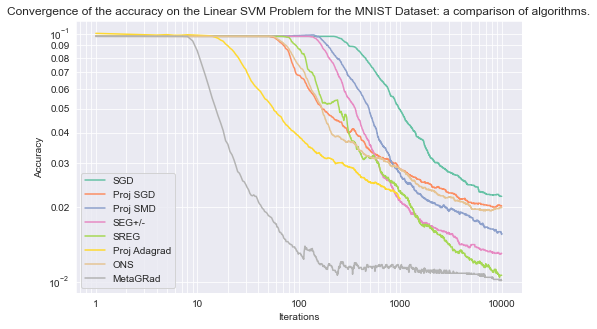

In [562]:
meta_results =  pd.read_csv("MetaGrad10000.csv")
errors = [errors_usgd, errors_sgdproj, errors_smdproj, errors_segproj, errors_adagrad,
          [1-acc for acc in accuracies_2], errors_sons, meta_results["error"]]
names = ["SGD", "Proj SGD", "Proj SMD", "SEG+/-", "SREG", "Proj Adagrad", "ONS", "MetaGRad"]

fig, ax = plt.subplots(figsize=(8,5))
for points, label in zip(errors, names):    
    ax.plot(range(1, len(points)), points[1:], label=label)

ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.grid(which='minor')
ax.set(xlabel="Iterations", ylabel="Accuracy")
plt.title("Convergence of the accuracy on the Linear SVM Problem for the MNIST Dataset: a comparison of algorithms.")
plt.show()